In [141]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# my module
import basicDataIO


In [6]:
dataFolder = Path("Z:/aoki/temp")
expName = "MRA010_240627_4"

### load timestamps

In [106]:
# load 2p timestamp
tp_ts_path = dataFolder / f"{expName}_2p.csv"
assert tp_ts_path.exists(), f"{tp_ts_path} does not exist"
tp_ts = basicDataIO.detect_bonsai_state_change(tp_ts_path)
tp_ts = tp_ts[::4] # as acquisition was x4 averaged 


# load camera timestamp
cam_ts_path = dataFolder / f"{expName}_cam1.csv"
assert cam_ts_path.exists(), f"{cam_ts_path} does not exist"
cam_ts = basicDataIO.detect_bonsai_state_change(cam_ts_path)

# load LED timestamp
led_ts_path = dataFolder / f"{expName}_LED.csv"
assert led_ts_path.exists(), f"{led_ts_path} does not exist"
led_ts = basicDataIO.detect_bonsai_state_change(led_ts_path)


100%|██████████| 79/79 [00:00<?, ?it/s]


### convert timestamps to seconds relative to 1st 2p frame

In [107]:
ref_ts = tp_ts[0]
tp_ts = np.array([(t - ref_ts).total_seconds() for t in tp_ts])
cam_ts = np.array([(t - ref_ts).total_seconds() for t in cam_ts])
led_ts = np.array([(t - ref_ts).total_seconds() for t in led_ts])

Text(0.5, 0, 'time (s)')

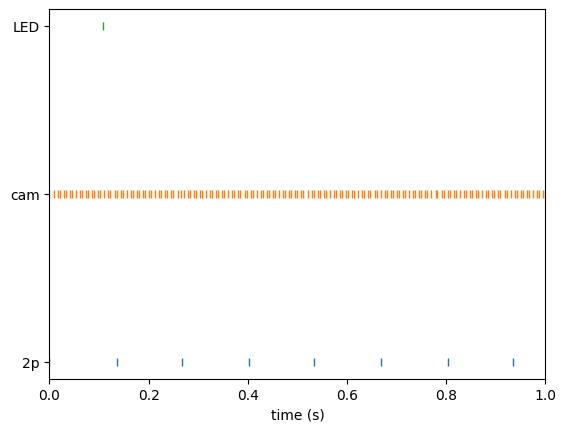

In [76]:
plt.plot(tp_ts, [1]*len(tp_ts), '|', label="2p")
plt.plot(cam_ts, [2]*len(cam_ts), '|', label="cam")
plt.plot(led_ts, [3]*len(led_ts), '|', label="LED")

plt.xlim(0, 1) # define x axis range
plt.yticks([1, 2, 3], ["2p", "cam", "LED"])
#plt.legend()
plt.xlabel("time (s)")


### load 2p trace (suite2p output)

In [77]:
F_path = dataFolder / f"{expName}/suite2p/plane0/F.npy"
assert F_path.exists(), f"{F_path} does not exist"
F = np.load(F_path)

Fneu_path = dataFolder / f"{expName}/suite2p/plane0/Fneu.npy"
assert Fneu_path.exists(), f"{Fneu_path} does not exist"
Fneu = np.load(Fneu_path)

iscell_path = dataFolder / f"{expName}/suite2p/plane0/iscell.npy"
assert iscell_path.exists(), f"{iscell_path} does not exist"
iscell = np.load(iscell_path)

assert F.shape[1] == len(tp_ts), f"length of F ({F.shape[1]}) and tp_ts ({len(tp_ts)}) do not match"

In [78]:
F_corr = F - Fneu * 0.7
# extract iscell = 1 cells (true cells)
F_corr = F_corr[iscell[:, 0] == 1, :]



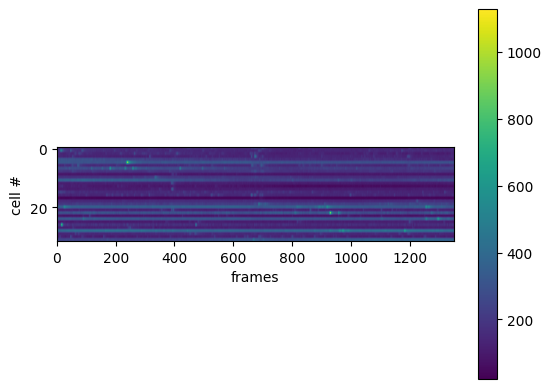

In [155]:
fig, ax = plt.subplots()
plt.imshow(F_corr)
plt.colorbar()
plt.xlabel("frames")
plt.ylabel("cell #")
ax.set_aspect(10)


### compute deltaF/F

In [80]:
dF_F = (F_corr - np.mean(F_corr, axis=1)[:, np.newaxis]) / np.mean(F_corr, axis=1)[:, np.newaxis]

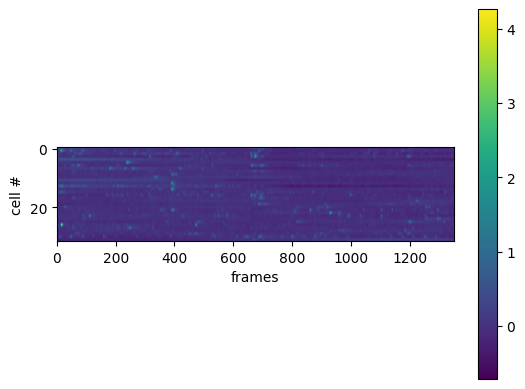

In [85]:
fig, ax = plt.subplots()
plt.imshow(dF_F)
plt.colorbar()
plt.xlabel("frames")
plt.ylabel("cell #")
ax.set_aspect(10)


(0.0, 10.0)

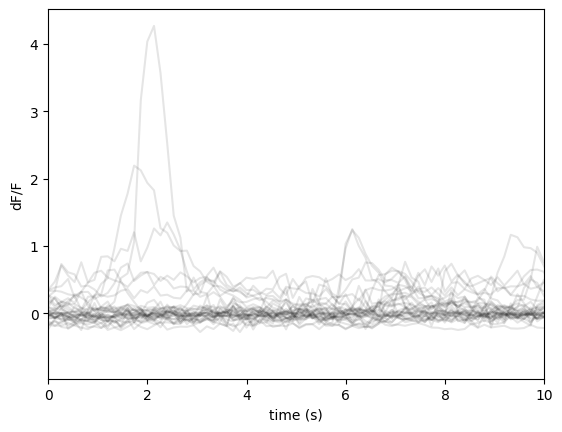

In [150]:
fig, ax = plt.subplots()
plt.plot(tp_ts, dF_F.T, 'k', alpha=0.1)
plt.xlabel("time (s)")
plt.ylabel("dF/F")
#plt.xlim(0, 10) # define x axis range

### plot LED on timing on it

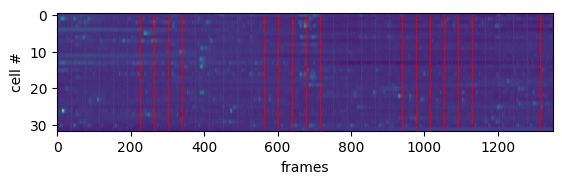

In [98]:
fig, ax = plt.subplots()
plt.imshow(dF_F)
plt.xlabel("frames")
plt.ylabel("cell #")
ax.set_aspect(10)

for i in range(len(led_ts)):
    # find the nearest frame
    idx = np.argmin(np.abs(np.array(tp_ts) - led_ts[i]))
    # vertical red line when LED is on
    plt.axvline(x=idx, color='r', linestyle='--', linewidth=0.5)



### align F_corr to LED onset

In [100]:
def alignedTensor(F_corr, ts, tp_ts, nPre=20, nPost=20):
    """
    Align a tensor F_corr to a time vector t, with number of frames before and after the time vector
    """
    # remove t earlier than t_wf(nPre)
    ts = ts[ts > tp_ts[nPre]]
    # remove t later than t_wf(end-nPost)
    ts = ts[ts < tp_ts[-nPost]]

    aligned = np.zeros((F_corr.shape[0], nPre + nPost, len(ts))) # nCells x tbin x nTrials
    for i, t_this in enumerate(t):
        idx = np.argmin(np.abs(tp_ts - t_this))
        aligned[:,:,i] = F_corr[:,idx-nPre:idx+nPost]
    return aligned, ts

In [117]:
F_aligned, led_ts_new = alignedTensor(dF_F, led_ts, tp_ts)

Text(0, 0.5, 'dF/F')

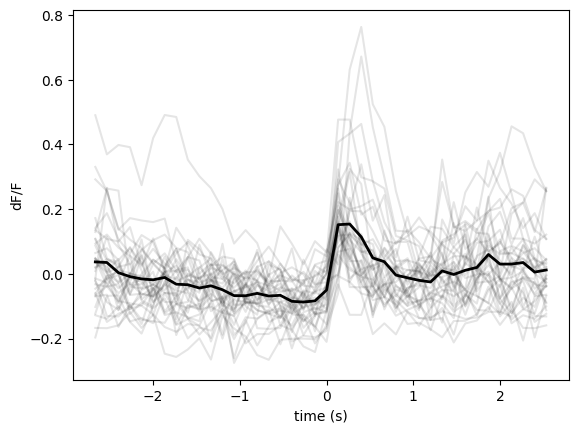

In [151]:
tbin = np.arange(-20, 20) /7.5

cell_idx = 15 # cell of interest

plt.plot(tbin, F_aligned[cell_idx], 'k', alpha=0.1)
plt.plot(tbin, np.mean(F_aligned[cell_idx], axis=1), 'k', linewidth=2) 
plt.xlabel("time (s)")
plt.ylabel("dF/F")

Text(0, 0.5, 'repeat #')

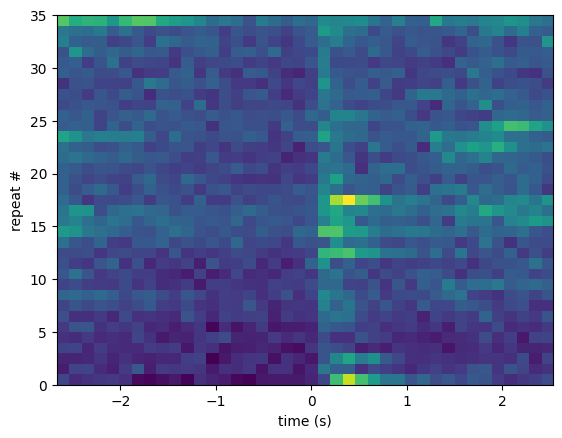

In [152]:
plt.imshow(F_aligned[cell_idx].T, aspect='auto',
           extent=[tbin[0], tbin[-1], 0, F_aligned.shape[2]])
plt.xlabel("time (s)")
plt.ylabel("repeat #")